In [1]:
from database import DatabaseXRD,snip
from numpy import loadtxt,diag,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter

from glob import glob

from scipy import signal
from numpy import fft,pad

$f = \dfrac{1}{f_{\max}}\displaystyle\sum_j f_j $

$f_j = I_j \gamma_j e^{\dfrac{-\frac{1}{2}(x-(\mu_j+\Delta_j))^2}{\sigma_j^2}}$

where $I$ is the intensity, $\gamma$ if correction to intensity 

$f = \dfrac{1}{f_{\max}}  \displaystyle\sum_j I_j \gamma_j e^{\dfrac{-\frac{1}{2}(x-(\mu_j+\Delta_j))^2}{\sigma_j^2}}$

$\dfrac{\partial f}{\partial \sigma^2_j} = \dfrac{\partial f_j}{\partial \sigma^2_j} - f_j\dfrac{1}{{f_\max}^2}\dfrac{\partial f_{\max}}{\partial \sigma^2_j} $

since $f_\max = 1$

$\dfrac{\partial f}{\partial \sigma^2_j} = \dfrac{\partial f_j}{\partial \sigma^2_j} - f_j\dfrac{\partial f_{\max}}{\partial \sigma^2_j} $

$\dfrac{\partial f_j}{\partial \sigma^2_j} = \dfrac{1}{2}\dfrac{[x-(\mu_j+\Delta_j)]^2}{\sigma_j^4}f_j$

following the above

$\dfrac{\partial f_j}{\partial \gamma_j} = I_j e^{\dfrac{-\frac{1}{2}(x-(\mu_j+\Delta_j))^2}{\sigma_j^2}} $

$\dfrac{\partial f_j}{\partial \Delta_j} = \dfrac{x - (\mu + \Delta)}{\sigma^2} f_j$

Rewriting $x$ as a function of the calibration curve

$f_j = I_j \gamma_j e^{-\dfrac{\frac{1}{2}(g(\Omega;a,b,c,d)-\mu_j)^2}{\sigma_j^2}}$

here $\Omega$ denotes channels

$x \equiv g(\Omega) = a + b\Omega + c\Omega^2 + d\Omega^3$ 

$f_j = I_j \gamma_j e^{-\dfrac{\frac{1}{2}(a + b\Omega + c\Omega^2 + d\Omega^3-\mu_j)^2}{\sigma_j^2}}$

$\dfrac{\partial f_j}{\partial a} = -\dfrac{ 1}{\sigma_j^2}(a + b\Omega + c\Omega^2 + d\Omega^3 - \mu_j) f_j$

$= -\dfrac{ 1}{\sigma_j^2}(g(\Omega) - \mu_j) f_j$

$\dfrac{\partial f_j}{\partial b} = -\dfrac{ \Omega (g(\Omega) - \mu_j) }{\sigma_j^2}f_j  $

$\dfrac{\partial f_j}{\partial c} = -\dfrac{ \Omega^2 (g(\Omega) - \mu_j) }{\sigma_j^2}f_j  $

$\dfrac{\partial f_j}{\partial d} = -\dfrac{ \Omega^3 (g(\Omega) - \mu_j) }{\sigma_j^2}f_j  $

Geometric fucntion

$\theta = \dfrac{180}{\pi} \tan^{-1}\left(\dfrac{x + a}{s}\right) + \beta$



$x$ and $a$ in the units of channels. $s$ is also in the units of channels and it rescales the detector range.
$\beta[^\circ]$ is an angle.

$\dfrac{\partial\theta}{\partial s} = -\dfrac{180}{\pi} \dfrac{a+x}{a^2+2ax+s^2+x^2}= -\dfrac{180}{\pi} \dfrac{a+x}{(a+x)^2+s^2}$

$\dfrac{\partial\theta}{\partial a} = \dfrac{180}{\pi} \dfrac{s}{a^2+2ax+s^2+x^2} = \dfrac{180}{\pi} \dfrac{s}{(a+x)^2+s^2}$

$\dfrac{\partial\theta}{\partial \beta} = 1$

$\theta = \dfrac{180}{\pi}\left[ \tan^{-1}\left(\dfrac{x + a}{z\sin\left(\beta\right)}\right) + \beta\right]$

here $\beta$ is in radians

$\dfrac{\partial\theta}{\partial z} = -\dfrac{180}{\pi}\dfrac{(a + x) \csc(\beta)}{z^2 + (a + x)^2 \csc^2(\beta)}$

$\dfrac{\partial\theta}{\partial a} = \dfrac{180}{\pi}\dfrac{z \csc(\beta)}{z^2 + (a + x)^2 \csc^2(\beta))}$

$\dfrac{\partial\theta}{\partial \beta} = \dfrac{180}{\pi} \left[ 1 - \dfrac{z (a + x) \cot(\beta) \csc(\beta)}{z^2 + (a + x)^2 \csc^2(\beta)} \right]$

Rewriting $x$ as a function of the calibration curve

$f_j = I_j \gamma_j e^{-\dfrac{\frac{1}{2}(g(\Omega;a,b,s)-\mu_j)^2}{\sigma_j^2}}$

here $\Omega$ denotes channels

$x \equiv g(\Omega) = \dfrac{180}{\pi} \tan^{-1}\left(\dfrac{\Omega + a}{s}\right) + \beta$ 

$f_j = I_j \gamma_j e^{-\dfrac{\frac{1}{2}\left[\dfrac{180}{\pi} \tan^{-1}\left(\dfrac{\Omega + a}{s}\right) + \beta-\mu_j\right]^2}{\sigma_j^2}}$

$\dfrac{\partial f_j}{\partial a} = -\dfrac{ 1}{\sigma_j^2}\dfrac{\partial g(\Omega)}{\partial a}(g(\Omega) - \mu_j) f_j$

In [2]:
class Spectra():
    
    def __init__(self,file=None):
        if file:
            self.read_from_file(file)
    
    def read_from_file(self,file):
        self.theta,self.intensity = loadtxt(file,unpack=True)
        self.channel = arange(1280)
        
    def calibration_fce(self,x,a,b,s):
        return (arctan((x+a)/s)) * 180 / pi + b
    
    def calibrate_from_file(self,file):           
        
        x,y = loadtxt(file,unpack=True)
        (self.a,self.b,self.s),(opt_var) = curve_fit(self.calibration_fce,x,y)
        
        self.theta = self.calibration_fce(self.channel,self.a,self.b,self.s)
        
        return self
    
    @property
    def _theta(self):
        return self.calibration_fce(self.channel,self.a,self.b,self.s)
    
    def snip(self,m = 24,s = 0):

        y = self.intensity
        y = y - snip(y,m) - s
        self.intensity = y/y.max()
        
        return self
    
    def convolve(self,off=128,w=32):
        win = signal.windows.gaussian(2*off-1,32)

        y = self.intensity
        y_pad = pad(y,(off,off),'edge')

        f = fft.rfft(y_pad)
        w = fft.rfft(win,y_pad.shape[-1])
        v = fft.irfft(w * f)

        v = v[off*2:]
        self.v = v/v.max()
        
        return self
        
    @property
    def x(self):
        return self.theta,self.intensity

In [3]:
class GaussNewton():
    
    def __init__(self,phase,spectra):
        
        self.phase = phase
        self.spectra = spectra
        
        self.phase.get_theta(l=[1.541,1.391],scale=[1.0,0.008])     
        f = (self.phase.theta < 51) & (self.phase.intensity > 0.003)
        
        self.mu = self.phase.theta[f]
        self.intensity = self.phase.intensity[f]
        
        self.sigma2 = array([0.02] * len(self.mu))
        self.gamma = ones(len(self.mu))

    def gauss(self,x,mu,sigma2):
        return exp(-0.5 * (x - mu)**2 / sigma2)
    
    def dsigma(self,x,mu,sigma2):
        return 0.5 * (x - mu)**2 / sigma2**2

    def da(self,channel,x,a,s,mu,sigma2):
        return -1.0/sigma2 * 180/pi * s/((a+channel)**2+s**2) * (x-mu)
    
    def ds(self,channel,x,a,s,mu,sigma2):
        return 1.0/sigma2 * 180/pi * (a+channel)/((a+channel)**2+s**2) * (x-mu)
    
    def db(self,x,mu,sigma2):
        return -1.0/sigma2 * (x - mu)

    def _sigma2(self):
        
        d = []
        z = zeros(len(self.spectra.channel))
        
        dsigma2 = []
        dgamma = []
        
        da = zeros(len(self.spectra.channel))
        dc = zeros(len(self.spectra.channel))
        
        db = zeros(len(self.spectra.channel))
        
        s = len(self.sigma2)
        
        """
        Loop over all peaks
        """
        x = self.spectra._theta
        y = self.spectra.intensity
        
        for mu,I,sigma2,gamma in zip(self.mu,self.intensity,self.sigma2,self.gamma):

            c = self.gauss(x,mu,sigma2)
            h = gamma * I * c
            z += h
            
            dsigma2 += [h * self.dsigma(x,mu,sigma2)]
            dgamma += [I * c]
                       
            da += h * self.da(self.spectra.channel,x,self.spectra.a,self.spectra.s,mu,sigma2)
            dc += h * self.ds(self.spectra.channel,x,self.spectra.a,self.spectra.s,mu,sigma2)
            
            db += h * self.db(x,mu,sigma2)
        
        z = z/z.max()
        jmax = z.argmax()
        dz = y - z
    
        d = dsigma2 + dgamma + [da,db,dc]
        
        d = array(d).T
        
        dfmax = z[:,newaxis] * d[jmax]
        d = d - dfmax

        dr = pinv(d) @ dz
        
        sigma2 = self.sigma2 + dr[:s]
        
        if any(sigma2<0):

            lower = (sigma2 < 0)
            d[:,:s][:,lower] *= 2

            dr = pinv(d) @ dz

            sigma2 = self.sigma2 + dr[:s]
        
        if any(sigma2<0):
            lower = (sigma2 < 0)
            d[:,:s][:,lower] = 0

            dr = pinv(d) @ dz

            sigma2 = self.sigma2 + dr[:s]
            
        self.z = z

        self.sigma2 = sigma2
        self.gamma += dr[s:2*s]
        
        #print(dr[2*s:])
        #print(self.spectra.a,self.spectra.b,self.spectra.s)
        
        self.spectra.a += dr[2*s]
        self.spectra.b += dr[2*s+1]
        self.spectra.s += dr[2*s+2]
    
        self.loss = sum(dz**2)
        
        
    def _abs(self):
        
        d = []
        z = zeros(len(self.spectra.channel))
        
        da = zeros(len(self.spectra.channel))
        dc = zeros(len(self.spectra.channel))
        
        db = zeros(len(self.spectra.channel))
        
        s = len(self.sigma2)
        
        """
        Loop over all peaks
        """
        x = self.spectra._theta
        y = self.spectra.v
        
        for mu,I,sigma2,gamma in zip(self.mu,self.intensity,self.sigma2,self.gamma):

            c = self.gauss(x,mu,sigma2)
            h = gamma * I * c
            z += h
                       
            da += h * self.da(self.spectra.channel,x,self.spectra.a,self.spectra.s,mu,sigma2)
            dc += h * self.ds(self.spectra.channel,x,self.spectra.a,self.spectra.s,mu,sigma2)
            
            db += h * self.db(x,mu,sigma2)
        
        z = z/z.max()
        jmax = z.argmax()
        dz = y - z
    
        d = [da,db,dc]
        
        d = array(d).T
        
        dfmax = z[:,newaxis] * d[jmax]
        d = d - dfmax

        dr = pinv(d) @ dz
                   
        self.z = z
        
        self.spectra.a += dr[0]*0.1
        self.spectra.b += dr[1]*0.1
        self.spectra.s += dr[2]*0.1
    
        self.loss = sum(dz**2)
        
    def _abs0(self):
        
        d = []
        z = zeros(len(self.spectra.channel))
        
        da = zeros(len(self.spectra.channel))
        dc = zeros(len(self.spectra.channel))
        
        db = zeros(len(self.spectra.channel))
        
        s = len(self.sigma2)
        
        """
        Loop over all peaks
        """
        x = self.spectra._theta
        y = self.spectra.intensity
        
        for mu,I,sigma2,gamma in zip(self.mu,self.intensity,self.sigma2,self.gamma):

            c = self.gauss(x,mu,sigma2)
            h = gamma * I * c
            z += h
                       
            da += h * self.da(self.spectra.channel,x,self.spectra.a,self.spectra.s,mu,sigma2)
            dc += h * self.ds(self.spectra.channel,x,self.spectra.a,self.spectra.s,mu,sigma2)
            
            db += h * self.db(x,mu,sigma2)
        
        z = z/z.max()
        jmax = z.argmax()
        dz = y - z
    
        d = [da,db,dc]
        
        d = array(d).T
        
        dfmax = z[:,newaxis] * d[jmax]
        d = d - dfmax

        dr = pinv(d) @ dz
                   
        self.z = z
        
        self.spectra.a += dr[0]*0.1
        self.spectra.b += dr[1]*0.1
        self.spectra.s += dr[2]*0.1
    
        self.loss = sum(dz**2)

In [4]:
d = DatabaseXRD().read_cifs('Database/')
calcite = d['Calcite'][0]

In [5]:
spectra = Spectra('roi_0.dat').calibrate_from_file('Calibrazione.txt').snip()
spectra.a,spectra.b,spectra.s

(-1264.3276462685521, 50.86970182232233, 2060.8620215486594)

In [6]:
g = GaussNewton(calcite,spectra)
for i in range(12):
    g._sigma2()

In [7]:
%matplotlib qt

figure(figsize=(15,6))
plot(g.spectra._theta,g.z)
plot(g.spectra._theta,g.spectra.intensity,'k',lw=1)

vlines(g.mu,0,1,'k',ls='--',lw=0.5)
vlines(g.mu,0,g.intensity * g.gamma,'r',ls='--')

ylim(0,1)
xlim(g.spectra._theta[0],g.spectra._theta[-1])

(19.323474143010568, 51.29294458260172)

In [8]:
plot(g.spectra.channel,g.spectra._theta)
a,b,s = g.spectra.a,g.spectra.b,g.spectra.s
a,b,s

(-1256.739240605666, 50.67466534389972, 2062.8188284000944)

In [9]:
spectra = Spectra('Calcite/Calcite300sL0154meno/Frame0001.dat').calibrate_from_file('Calibrazione.txt').snip(s=64)
spectra.convolve()

spectra.a,spectra.b,spectra.s

(-1264.3276462685521, 50.86970182232233, 2060.8620215486594)

In [10]:
print('init:',spectra.a,spectra.b,spectra.s)

g = GaussNewton(calcite,spectra)
g.sigma2 = [1]*len(g.sigma2)

print(g.spectra._theta[0],g.spectra._theta[-1])

for i in range(128):
    g._abs()

init: -1264.3276462685521 50.86970182232233 2060.8620215486594
19.340812403382703 51.277613527342126


In [11]:
g.sigma2 = [0.05]*len(g.sigma2)

for i in range(128):
    g._sigma2()

(20.327062359853624, 54.117736929387)

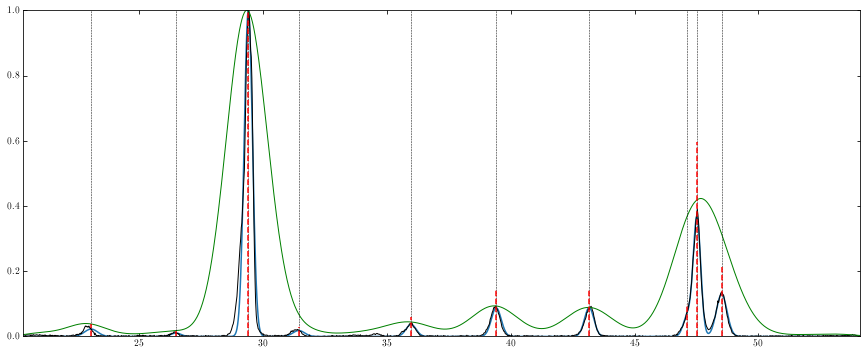

In [12]:
#%matplotlib qt
%matplotlib inline
figure(figsize=(15,6))
plot(g.spectra._theta,g.z)
plot(g.spectra._theta,g.spectra.intensity,'k',lw=1)
plot(g.spectra._theta,g.spectra.v,'g',lw=1)

vlines(g.mu,0,1,'k',ls='--',lw=0.5)
vlines(g.mu,0,g.intensity * g.gamma,'r',ls='--')

ylim(0,1)
xlim(g.spectra._theta[0],g.spectra._theta[-1])

In [13]:
%matplotlib qt
figure(figsize=(15,6))
plot(g.spectra.channel,g.z)
plot(g.spectra.channel,g.spectra.intensity,'k',lw=1)

In [14]:
plot(g.spectra.channel,g.spectra._theta)

In [15]:
files = glob('Calcite/*/Frame0001.dat')

def ssort(x):
    _s = x.find('L')
    t = x[_s+1:_s+5]
    t = int(t)
    if x[_s+5] == 'm':
        t *= -1
    return t

G = []
for file in sorted(files,key=ssort):
    print(file,ssort(file))
    
    spectra = Spectra(file).calibrate_from_file('Calibrazione.txt').snip(s=64)
    spectra.convolve()
    


Calcite/Calcite300sL0154meno/Frame0001.dat -154
Calcite/Calcite300sL0104meno/Frame0001.dat -104
Calcite/Calcite300sL0054meno/Frame0001.dat -54
Calcite/Calcite300sL0005/Frame0001.dat 5
Calcite/Calcite300sL0057/Frame0001.dat 57
Calcite/Calcite300sL0108/Frame0001.dat 108
Calcite/Calcite300sL0149/Frame0001.dat 149


In [16]:
files = glob('Calcite/*/Frame0001.dat')

def ssort(x):
    _s = x.find('L')
    t = x[_s+1:_s+5]
    t = int(t)
    if x[_s+5] == 'm':
        t *= -1
    return t

G = []
for file in sorted(files,key=ssort):
    print(file,ssort(file))
    spectra = Spectra(file).calibrate_from_file('Calibrazione.txt').snip(s=64)
    spectra.convolve()
    g = GaussNewton(calcite,spectra)
    g.sigma2 = [1]*len(g.sigma2)

    for i in range(128):
        g._abs()
        
    g.sigma2 = [0.1]*len(g.sigma2)
    for i in range(128):
        g._sigma2()
        
    #if g.sigma2[0] > 0.03:
    #    g.sigma2[0] = 0.03
        
    #g.gamma[0] = 1.0
    
    #for i in range(128):
    #    g._abs0()
    p=(find_peaks(spectra.intensity,height=0.14,distance=34))
    
    g.p = p
    g.file = file
    g.zeta = ssort(file)
        
    G += [g]
    
    #plot(g.spectra.channel,g.spectra.intensity,'k',lw=1)

Calcite/Calcite300sL0154meno/Frame0001.dat -154
Calcite/Calcite300sL0104meno/Frame0001.dat -104
Calcite/Calcite300sL0054meno/Frame0001.dat -54
Calcite/Calcite300sL0005/Frame0001.dat 5
Calcite/Calcite300sL0057/Frame0001.dat 57
Calcite/Calcite300sL0108/Frame0001.dat 108
Calcite/Calcite300sL0149/Frame0001.dat 149


In [130]:
for g in G:
    print(len(g.p[0]),g.p[0])

2 [ 388 1050]
2 [ 385 1048]
2 [ 383 1043]
2 [ 379 1038]
4 [ 379  752 1034 1069]
6 [ 374  616  750  880 1030 1066]
5 [ 373  613  877 1028 1063]


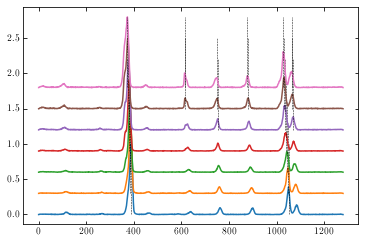

In [24]:
for i,g in enumerate(G):
    plot(g.spectra.channel,g.spectra.intensity+i*0.3)
    vlines(g.p[0],i*0.3,i*0.3+1,'k',ls='--',lw=0.5)

In [27]:
%matplotlib qt

for i,g in enumerate(G):
    plot(g.spectra._theta,g.z+i*0.3)
    plot(g.spectra._theta,g.spectra.intensity+i*0.3)
    
    vlines(g.mu,0,3,'k',ls='--',lw=0.5)

Calcite/Calcite300sL0154meno/Frame0001.dat -1143.1120926325152 50.209977100410775 1989.3053310870762
Calcite/Calcite300sL0104meno/Frame0001.dat -1101.6559310356163 49.084865143873564 2003.0450374232132
Calcite/Calcite300sL0054meno/Frame0001.dat -1087.3032247356518 48.782644429687885 2003.1855841080192
Calcite/Calcite300sL0005/Frame0001.dat -1107.8454550226295 49.54853355391021 1985.8252571345818
Calcite/Calcite300sL0057/Frame0001.dat -1132.0604553673309 50.346640352693065 1975.2348104274247
Calcite/Calcite300sL0108/Frame0001.dat -1125.1066143168728 50.236130450294816 1979.3902936014983
Calcite/Calcite300sL0149/Frame0001.dat -1109.8975479083344 49.853502462177296 1986.5291922318656


(20.0, 55.0)

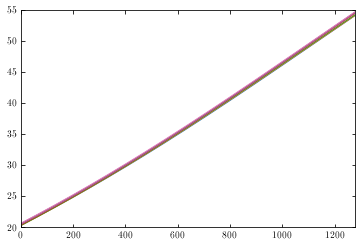

In [18]:
%matplotlib inline
for g in G:
    plot(g.spectra.channel,g.spectra._theta,lw=1)
    print(g.file,g.spectra.a,g.spectra.b,g.spectra.s)
    

xlim(0,1280)
ylim(20,55)

In [19]:
zeta = array([g.zeta for g in G])
ga = array([g.spectra.a for g in G])
gb = array([g.spectra.b for g in G])
gs = array([g.spectra.s for g in G])

gz = gs / sin(gb/180*pi)

gsigma = array([g.sigma2 for g in G])
ggamma = array([g.gamma for g in G])

gt0 = array([g.spectra._theta[0] for g in G])
gtm = array([g.spectra._theta[-1] for g in G])

In [20]:
ggamma

array([[0.5575199 , 2.71789606, 2.08777983, 1.66753471, 0.56001013,
        0.91240097, 1.23424173, 2.03962332, 3.84165359, 1.2834447 ],
       [0.22170979, 1.60156651, 1.9098883 , 1.21694565, 0.46975541,
        0.83759581, 0.96980983, 1.94889619, 3.42660647, 1.11256042],
       [0.24171293, 2.47461567, 1.66102868, 1.22784872, 0.40892186,
        0.73980734, 0.75329612, 1.34371562, 2.41354019, 0.91453656],
       [0.24917069, 2.76322063, 1.42299951, 1.15554877, 0.451938  ,
        0.71229787, 0.76941891, 0.44653464, 1.71892333, 0.85891389],
       [0.48358391, 1.92320413, 1.85707259, 1.83517468, 0.94869467,
        1.27553659, 1.44254309, 0.96784318, 3.09913904, 1.52333798],
       [0.74087714, 0.71000265, 1.65733473, 1.99363226, 1.36994167,
        1.09355608, 1.5993836 , 1.48832891, 3.50214269, 1.52161774],
       [1.04305967, 0.69112955, 1.95210573, 2.66743328, 2.17759546,
        1.26386783, 1.9858282 , 2.33570245, 4.74488978, 1.98484275]])

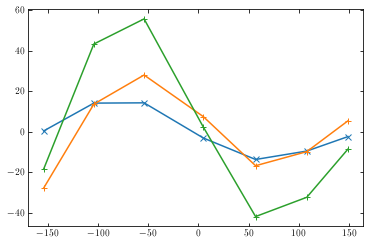

In [21]:
%matplotlib inline

plot(zeta,gs-gs.mean(),'x-')
plot(zeta,ga-ga.mean(),'+-')
plot(zeta,gz-gz.mean(),'+-')

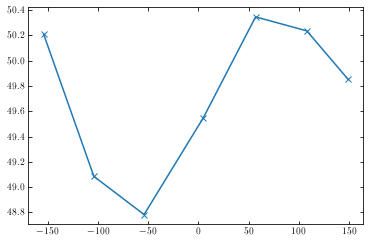

In [22]:
%matplotlib inline

plot(zeta,gb,'x-')

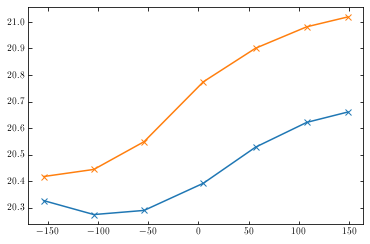

In [23]:
%matplotlib inline

plot(zeta,gt0,'x-')
plot(zeta,gtm-33.7,'x-')